

# Breaking Hardware CWM on CW305 FPGA

This tutorial relies on previous knowledge from the SCA101 course notebooks (in `../courses/sca101/`); make sure you go through these first to understand how a CPA attack works.

In this notebook, we'll apply knowledge from sca101 to break a hardware AES implementation on the CW305 Artix FPGA.

Some out-of-date background on the target FPGA project is can be found here: [Tutorial CW305-1 Building a Project](http://wiki.newae.com/Tutorial_CW305-1_Building_a_Project) (ignore the "capture setup" section, which uses the obsolete ChipWhisperer GUI; this notebook shows all you need to know about capture setup on the CW305 with Jupyter).

## Capture Setup

Setup is somewhat similar to other targets, except that we are using an external clock (driven from the FPGA). We'll also do the rest of the setup manually:

In [1]:
FPGA_ID='100t' # change if not using K100t CW305    

In [2]:
import chipwhisperer as cw
scope = cw.scope()
scope.gain.db = 25
scope.adc.samples = 2500
scope.adc.offset = 0
scope.adc.basic_mode = "rising_edge"
scope.trigger.triggers = "tio4"
scope.io.tio1 = "serial_rx"
scope.io.tio2 = "serial_tx"
scope.io.hs2 = "disabled"


In [3]:
import chipwhisperer as cw
print(cw.__file__)


C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\chipwhisperer\__init__.py


In [4]:
#target = cw.target(scope, cw.targets.CW305, fpga_id='35t', force=False)_7LSB_C18_bias6_Star1.bit"
#bitpath = "cw305_top_extended_high_signal.bit"
#bitpath = "cw305_top_with_NTT.bit"
#bitpath = "cw305_top_with_Keep_trigger.bit"
#bitpath = "cw305_top_128_Output_with_RST.bit"
#bitpath = "cw305_top_128_bits_plaintext.bit"
#bitpath = "cw305_top_128bits_PT.bit"
#bitpath = "cw305_top_Snowv_17thMarch.bit" 
#bitpath = "cw305_top_with_load.bit"
#bitpath = "cw305_top_March_20_25_Tb.bit"
#bitpath = "cw305_top_cwm_Apr1.bit"
# bitpath = "cw305_top_Apr8_OneClk_PowerTrace.bit"
#bitpath = "cw305_top_1clkCycle_i2.bit"
#bitpath = "cw305_top_Apr8.bit"
#bitpath = "cw305_top_i_CWM_concatenated.bit"
#bitpath = "cw305_top_aes_127_0.bit"


#bitpath = "cw305_top_check.bit"
# bitpath = "cw305_top_128_aes_ct_full.bit" 
#bitpath = "cw305_top_test_32'sd0_in5th_word.bit"
#bitpath = "cw305_top_after_implementation.bit"
#bitpath = "cw305_top_Apr2.bit"
#bitpath = "cw305_top_NTT_bgn_modified.bit"
# target = cw.target(scope, cw.targets.CW305, fpga_id=FPGA_ID, bsfile=bitpath,force=True)

In [5]:
bitpath = "cw305_top_midway_aes_pt_232.bit"
target = cw.target(scope, cw.targets.CW305, fpga_id=FPGA_ID, bsfile=bitpath,force=True)

Before setting the ADC clock, we connect to the CW305 board. Here we'll need to specify our bitstream file to load as well as the usual scope and target_type arguments.

Pick the correct bitfile for your CW305 board (e.g. either '35t' or '100t'). By setting `force=False`, the bitfile will only be programmed if the FPGA is uninitialized (e.g. after powering up). Change to `force=True` to always program the FPGA (e.g. if you have generated a new bitfile).

Next we set all the PLLs. We enable CW305's PLL1; this clock will feed both the target and the CW ADC. As explained [here](http://wiki.newae.com/Tutorial_CW305-1_Building_a_Project#Capture_Setup), **make sure the DIP switches on the CW305 board are set as follows**:
- J16 = 0
- K16 = 1

In [6]:
!pwd

/c/Users/user/ChipWhisperer5_64/cw/home/portable/chipwhisperer/jupyter


CW-Husky requires a different setup when the ADC clock is driven by the target:

In [7]:
target.vccint_set(1.0)
# we only need PLL1:
target.pll.pll_enable_set(True)
target.pll.pll_outenable_set(False, 0)
target.pll.pll_outenable_set(True, 1)
target.pll.pll_outenable_set(True, 2)

# run at 10 MHz:
target.pll.pll_outfreq_set(33E6, 1)
# target.pll.pll_outfreq_set(100E6, 2) #####################Make sure to match this to the frquency used in the Verilog Constraints file for which the 
# Viavdo implemented this. 
target.pll.pll_outfreq_set(166E6, 2)

# 1ms is plenty of idling time
target.clkusbautooff = True
target.clksleeptime = 1

In [8]:
if scope._is_husky:
    scope.clock.clkgen_freq = 132e6 # This is always 4 times the main frequency
    scope.clock.clkgen_src = 'extclk'
    scope.clock.adc_mul = 10
    # if the target PLL frequency is changed, the above must also be changed accordingly
else:
    scope.clock.clkgen_freq = 132e6
    scope.clock.clkgen_src = 'extclk'
    # scope.clock.adc_mul = 10
    #scope.clock.adc_src = "extclk_x4"

Ensure the ADC clock is locked:

In [9]:
import time
for i in range(5):
    scope.clock.reset_adc()
    time.sleep(1)
    if scope.clock.adc_locked:
        break 
assert (scope.clock.adc_locked), "ADC failed to lock"

Occasionally the ADC will fail to lock on the first try; when that happens, the above assertion will fail (and on the CW-Lite, the red LED will be on). Simply re-running the above cell again should fix things.

## Trace Capture
Below is the capture loop. The main body of the loop loads some new plaintext, arms the scope, sends the key and plaintext, then finally records and appends our new trace to the `traces[]` list.

Because we're capturing 5000 traces, this takes a bit longer than the attacks against software AES implementations.

Note that the encryption result is read from the target and compared to the expected results, as a sanity check.

In [10]:
project_file = "projects/Tutorial_HW_CWM.cwp"
project = cw.create_project(project_file, overwrite=True)

In [13]:
# Define the plaintext to match the testbench input
text = bytearray([
    0x00, 0x00, 0x00, 0x00,
    0x22, 0x00, 0x00, 0x00,
    0x00, 0x00, 0x00, 0x00,
    0x00, 0x00, 0x00, 0x03
])
expected_output = 0x002d523a_00000000_00074965_00000000

# Assuming 'scope' and 'target' are already set up
# Define the key as a 32-byte array of zeros
key = bytearray([0x00] * 32)

# Send the plaintext to the FPGA
target.simpleserial_write('p', text)

# Trigger the encryption operation
#target.simpleserial_write('g', bytearray([0x01]))

# Capture the power trace
ret = cw.capture_trace(scope, target, text, key)

# Check if the capture was successful
if ret:
    # 'ret.wave' contains the power trace
    # 'ret.textout' contains the ciphertext output from the FPGA
    print("Ciphertext:", ret.textout.hex())
else:
    print("Capture failed.")


Ciphertext: 002d523a000000000007496500000000


In [14]:
"""from tqdm import tqdm
import numpy as np
import random
import pickle
import chipwhisperer as cw

N = 1000  # Traces per byte
key = bytearray([0x00] * 32)  # Confirm size matches your design
print("🔐 Using Key:", key.hex())

total_traces = []
total_plaintexts = []
total_ciphertexts = []

for byte_index in range(16):
    print(f"\n[INFO] Varying byte index {byte_index}...")

    traces = []
    textin = []
    textout = []

    for i in tqdm(range(N), desc=f"Byte {byte_index}"):
        text = bytearray([0x00] * 16)
        text[byte_index] = random.getrandbits(8)

        target.simpleserial_write('p', text)

        ret = cw.capture_trace(scope, target, text, key)
        if not ret:
            print(f"[WARN] Capture failed at trace {i}")
            continue

        # Optional debug
        # print(f"[DEBUG] Trace {i} | PT: {text.hex()} → CT: {ret.textout.hex()}")

        traces.append(ret.wave)
        textin.append(text.copy())
        textout.append(ret.textout)

    with open(f"traces_byte_{byte_index}.pkl", "wb") as f:
        pickle.dump(traces, f)
    with open(f"plaintexts_byte_{byte_index}.pkl", "wb") as f:
        pickle.dump(textin, f)
    with open(f"ciphertexts_byte_{byte_index}.pkl", "wb") as f:
        pickle.dump(textout, f)

    total_traces.extend(traces)
    total_plaintexts.extend(textin)
    total_ciphertexts.extend(textout)"""


'from tqdm import tqdm\nimport numpy as np\nimport random\nimport pickle\nimport chipwhisperer as cw\n\nN = 1000  # Traces per byte\nkey = bytearray([0x00] * 32)  # Confirm size matches your design\nprint("🔐 Using Key:", key.hex())\n\ntotal_traces = []\ntotal_plaintexts = []\ntotal_ciphertexts = []\n\nfor byte_index in range(16):\n    print(f"\n[INFO] Varying byte index {byte_index}...")\n\n    traces = []\n    textin = []\n    textout = []\n\n    for i in tqdm(range(N), desc=f"Byte {byte_index}"):\n        text = bytearray([0x00] * 16)\n        text[byte_index] = random.getrandbits(8)\n\n        target.simpleserial_write(\'p\', text)\n\n        ret = cw.capture_trace(scope, target, text, key)\n        if not ret:\n            print(f"[WARN] Capture failed at trace {i}")\n            continue\n\n        # Optional debug\n        # print(f"[DEBUG] Trace {i} | PT: {text.hex()} → CT: {ret.textout.hex()}")\n\n        traces.append(ret.wave)\n        textin.append(text.copy())\n        text

In [15]:
from tqdm import tqdm
import numpy as np
import random
import pickle
import chipwhisperer as cw  # Make sure you have your CW setup
# import matplotlib.pyplot as plt (optional)

N = 7000  # Traces per plaintext
# key = bytearray([0x00] * 32)

key = bytearray([
    0xab, 0xcd, 0xef, 0x01, 0x12, 0x34, 0x56, 0x78,
    0xde, 0xad, 0xbe, 0xef, 0x87, 0x65, 0x43, 0x21, 
    0xab, 0xcd, 0xef, 0x01, 0x12, 0x34, 0x56, 0x78,
    0xde, 0xad, 0xbe, 0xef, 0x87, 0x65, 0x43, 0x21
])
# key2 = bytearray(b'\x2b\x7e\x15\x16\x28\xae\xd2\xa6\xab\xf7\x15\x88\x09\xcf\x4f\x3c\x2b\x7e\x15\x16\x28\xae\xd2\xa6\xab\xf7\x15\x88\x09\xcf\x4f\x3c')
# inter SUBKEY value at 14th Round is 


print("🔐 Using Key:", key.hex())

total_traces = []
total_plaintexts = []
total_ciphertexts = []

# Loop over all traces
for i in tqdm(range(N), desc="Collecting traces"):
    # Generate a random 128-bit plaintext (16 bytes)
    plaintext = bytearray(random.getrandbits(8) for _ in range(16))
    
    # Store the plaintext (input text)
    total_plaintexts.append(plaintext.copy())
    target.simpleserial_write('p', plaintext)
    # Capture the corresponding trace
    ret = cw.capture_trace(scope, target, plaintext, key)

    if not ret:
        print(f"[WARN] Capture failed at trace {i}")
        continue

    # Store the captured trace and ciphertext (output text)
    total_traces.append(ret.wave)
    total_ciphertexts.append(ret.textout)

# Save the collected results
with open(f"traces_CWM.pkl", "wb") as f:
    pickle.dump(total_traces, f)
with open(f"plaintexts_CWM.pkl", "wb") as f:
    pickle.dump(total_plaintexts, f)
with open(f"ciphertexts_CWM.pkl", "wb") as f:
    pickle.dump(total_ciphertexts, f)

print("✅ Collection complete. Data saved.")


🔐 Using Key: abcdef0112345678deadbeef87654321abcdef0112345678deadbeef87654321


✅ Collection complete. Data saved.


## Ananlysis of TRACES received 

In [18]:
import pickle

# Load the saved traces, plaintexts, and ciphertexts
with open("traces_CWM.pkl", "rb") as f:
    traces_cwm = pickle.load(f)

with open("plaintexts_CWM.pkl", "rb") as f:
    plaintexts_cwm = pickle.load(f)

with open("ciphertexts_CWM.pkl", "rb") as f:
    ciphertexts_cwm = pickle.load(f)


In [20]:
print("Sample Trace (first 5):\n")
print(traces_cwm[:5])

print("\nCorresponding Plaintexts:\n")
print(plaintexts_cwm[:5])

print("\nCorresponding Ciphertexts:\n")
print(ciphertexts_cwm[:5])


Sample Trace (first 5):

[array([-0.00976562, -0.01269531, -0.00097656, ..., -0.02441406,
       -0.03417969, -0.015625  ]), array([-0.00292969, -0.01269531, -0.03515625, ..., -0.01953125,
       -0.02636719, -0.0234375 ]), array([-0.01269531, -0.00390625, -0.02734375, ..., -0.02832031,
       -0.01953125, -0.03222656]), array([-0.00390625, -0.00976562, -0.04101562, ..., -0.0234375 ,
       -0.02441406, -0.02929688]), array([-0.00585938,  0.00097656, -0.0078125 , ..., -0.02832031,
       -0.01953125, -0.02441406])]

Corresponding Plaintexts:

[bytearray(b'\x98OC(\xdf\xc1BW!\xf7a\xce\xfc\x1a\x01\xe6'), bytearray(b'D\x08\xad\x95\xee9\xd2\x10\xb3\xf1wEJ\x8c\x8e\xa6'), bytearray(b'\xef\xe7\xec^\x06\xed58\xba(7\xe8\xe3\xebQ\x8c'), bytearray(b'\x90\xce[RA\xd2\x9b\x0e\xbdj\x81\xea\x02\x8e!E'), bytearray(b'o[\xd4F\x18\xff$\xf7T\xccm\x04o\xf1\x96\x87')]

Corresponding Ciphertexts:

[bytearray(b'\xff\xe6\xdaR\xff\xff\xab\x95\xff\xec\x15\t\x00,\x89\x81'), bytearray(b'\x00!\x1cJ\x00*W\xa4\xff\xd5\

In [21]:
# Print header
print(f"{'Index':<5} | {'Plaintext (hex)':<40} | {'Ciphertext (hex)'}")
print("-" * 90)

# Loop through a few samples (first 5)
for i in range(5):
    pt_hex = plaintexts_cwm[i].hex()
    ct_hex = ciphertexts_cwm[i].hex()
    print(f"{i:<5} | {pt_hex:<40} | {ct_hex}")


Index | Plaintext (hex)                          | Ciphertext (hex)
------------------------------------------------------------------------------------------
0     | 984f4328dfc1425721f761cefc1a01e6         | ffe6da52ffffab95ffec1509002c8981
1     | 4408ad95ee39d210b3f177454a8c8ea6         | 00211c4a002a57a4ffd5de6affd8631c
2     | efe7ec5e06ed3538ba2837e8e3eb518c         | 002874a2ffe5a921fffd0c53fffd07f9
3     | 90ce5b5241d29b0ebd6a81ea028e2145         | 001ab9ed002571e7003b39c5000b6f86
4     | 6f5bd44618ff24f754cc6d046ff19687         | 004e3c6f0037ab29001bdf9dffe676a7


In the VIVADO testbench for CW305; we do this:
      write_bytes(0, 16, `REG_CRYPT_TEXTIN, {32'h00000000, 32'h008e0000, 32'h00b20000, 32'h00000000}); (This serves as our PT; one of the multiplier)
      write_bytes(0, 16, `REG_CRYPT_KEY, {32'habcdef01, 32'h12345678, 32'hdeadbeef, 32'h87654321});(This serves as our Key)

      So, in1 = {32'h00000000, 32'h00b20000, 32'h008e0000, 32'h00000000} (Note: we send A, B, C, D which gets turned to D, C, B, A)as one of the multiplier.
      So in the Behavioral Waveform see that b ={ } and a = { }. Elaborated in the picture next.
********************************************************************************************************************************************************

    For that: Select the Cell and change it into Markdown Cell. Enter this text with the jpg file path and its description. For that we need to Press ESC and then Outer border will get broadened.  Then press "M". 
     Next, press enter. 
    ![Description of Image](CWM_TB_WaveForm.jpg)

<figure>
  <img src="CWM_TB_WaveForm.jpg" alt="Description of Image" width="700" height="900">
  <figcaption>This is the way multiplication and montegomery reduction is happening. See Vivado project March_20_25_NTT_Attack to understand the signals.</figcaption>
</figure>


[INFO] Loaded 7000 traces.


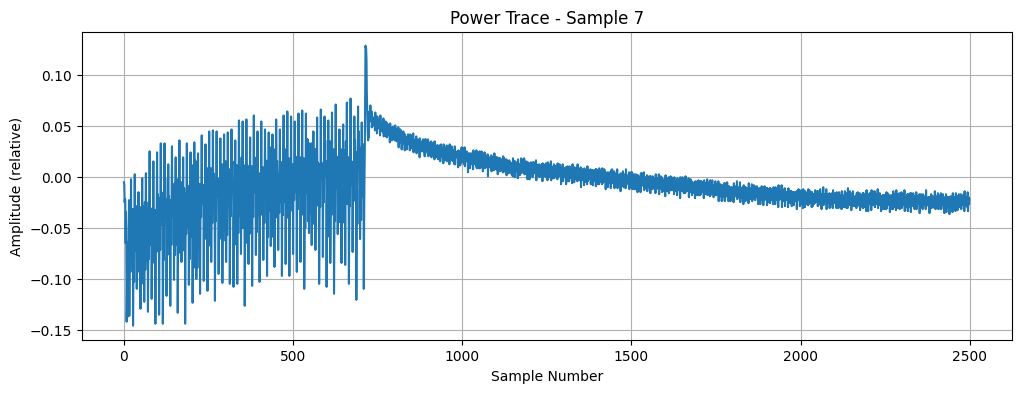

In [106]:
import pickle
import os
import matplotlib.pyplot as plt

# === Load and Plot ===
with open("traces_CWM.pkl", "rb") as f:
    traces = pickle.load(f)

print(f"[INFO] Loaded {len(traces)} traces.")

if len(traces) > 0:
    plt.figure(figsize=(12, 4))
    plt.plot(traces[19])  # zoom in on area of interest
    plt.title("Power Trace - Sample 7")
    plt.xlabel("Sample Number")
    plt.ylabel("Amplitude (relative)")
    plt.grid(True)
    plt.show()
else:
    print("[ERROR] No valid traces in file.")

In [107]:
import pickle

# Load the full traces
with open("traces_CWM.pkl", "rb") as f:
    full_traces = pickle.load(f)

# Truncate each trace to the first 770 sample points
trimmed_traces = [trace[:770] for trace in full_traces]

# Save the trimmed traces back into a new pickle file (or overwrite, if you want)
with open("traces_CWM_trimmed.pkl", "wb") as f:
    pickle.dump(trimmed_traces, f)


In [108]:
import pickle

# Load the saved traces, plaintexts, and ciphertexts
with open("traces_CWM_trimmed.pkl", "rb") as f:
    traces_cwm = pickle.load(f)

with open("plaintexts_CWM.pkl", "rb") as f:
    plaintexts_cwm = pickle.load(f)

with open("ciphertexts_CWM.pkl", "rb") as f:
    ciphertexts_cwm = pickle.load(f)

[INFO] Loaded 7000 traces.


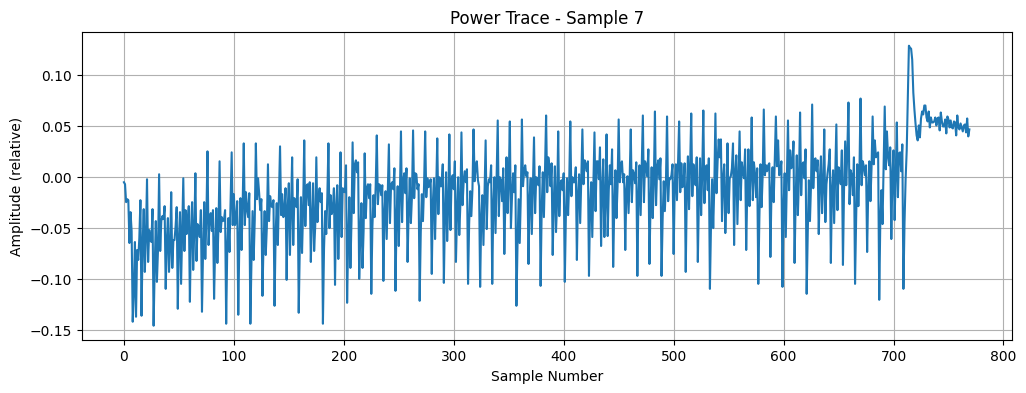

In [109]:
import pickle
import os
import matplotlib.pyplot as plt


print(f"[INFO] Loaded {len(traces)} traces.")

if len(traces_cwm) > 0:
    plt.figure(figsize=(12, 4))
    plt.plot(traces_cwm[19])  # zoom in on area of interest
    plt.title("Power Trace - Sample 7")
    plt.xlabel("Sample Number")
    plt.ylabel("Amplitude (relative)")
    plt.grid(True)
    plt.show()
else:
    print("[ERROR] No valid traces in file.")

## Reverse the words in the Plaintexts send; from A B C D to D A B C where each letter is a signed word of 32 bits 

In [112]:
################################################################ REVERSE PLAINTEXTS ####################################################################

In [113]:
import pickle

# Load the plaintexts
with open("plaintexts_CWM.pkl", "rb") as f:
    textin = pickle.load(f)

# Function to reverse 32-bit chunks
def reverse_plaintext(pt):
    chunks = [pt[i:i+4] for i in range(0, 16, 4)]  # Split into 4 chunks (each 32 bits)
    reversed_pt = chunks[::-1]  # Reverse the order of chunks
    return b"".join(reversed_pt).hex()  # Convert to hex after reversing

# Transform all plaintexts
reversed_plaintexts = [reverse_plaintext(pt) for pt in textin]

# Save transformed plaintexts
with open("reversed_plaintexts_cwm.pkl", "wb") as f:
    pickle.dump(reversed_plaintexts, f)

# Print first 5 transformed plaintexts
for i in range(5):
    print(f"Reversed Plaintext {i+1}: {reversed_plaintexts[i]}")
    print(f"Plaintext {i+1}       : {textin[i].hex()}")


with open("plaintexts_CWM.pkl", "rb") as f:
    plaintexts = pickle.load(f)
print(f"Type: {type(plaintexts)}")

# If it's a NumPy array or list, print the shape or length
if isinstance(plaintexts, list):
    print(f"Number of plaintexts: {len(plaintexts)}")
    print(f"First plaintext length: {len(plaintexts[0]) if plaintexts else 'Empty'}")
elif isinstance(plaintexts, dict):
    print(f"Keys: {plaintexts.keys()}")
elif isinstance(plaintexts, np.ndarray):
    print(f"Shape: {plaintexts.shape}")
else:
    print(f"Unknown structure: {plaintexts}")

Reversed Plaintext 1: fc1a01e621f761cedfc14257984f4328
Plaintext 1       : 984f4328dfc1425721f761cefc1a01e6
Reversed Plaintext 2: 4a8c8ea6b3f17745ee39d2104408ad95
Plaintext 2       : 4408ad95ee39d210b3f177454a8c8ea6
Reversed Plaintext 3: e3eb518cba2837e806ed3538efe7ec5e
Plaintext 3       : efe7ec5e06ed3538ba2837e8e3eb518c
Reversed Plaintext 4: 028e2145bd6a81ea41d29b0e90ce5b52
Plaintext 4       : 90ce5b5241d29b0ebd6a81ea028e2145
Reversed Plaintext 5: 6ff1968754cc6d0418ff24f76f5bd446
Plaintext 5       : 6f5bd44618ff24f754cc6d046ff19687
Type: <class 'list'>
Number of plaintexts: 7000
First plaintext length: 16


In [114]:
###############################################      KNOWN VALUE CORRELATION      ############################################################

In [116]:
verilog_output = """
b = {
    32'sd116795, 32'sd6525254, 32'sd6726660, 32'sd446995,
     32'sd4543412, 32'sd953375, 32'sd3015564, 32'sd963977,
	32'sd1633725, 32'sd1776882, 32'sd8287968, 32'sd7736493, 32'sd935442, 32'sd1507897, 32'sd83392, 32'sd4494294, 
	32'sd2688649, 32'sd6545940, 32'sd8333443, 32'sd5813536, 32'sd1254113, 32'sd1623740, 32'sd3697723, 32'sd2951674, 
	32'sd772666, 32'sd2456439, 32'sd5021077, 32'sd1959735, 32'sd7705741, 32'sd252617, 32'sd2681594, 32'sd6869272, 
	32'sd7085522, 32'sd126526, 32'sd6181484, 32'sd5887408, 32'sd2600944, 32'sd3209806, 32'sd5597025, 32'sd3523579, 
	32'sd789718, 32'sd1387386, 32'sd1791399, 32'sd1097964, 32'sd3957939, 32'sd3284197, 32'sd2018637, 32'sd3264935, 
	32'sd2033505, 32'sd3857922, 32'sd917617, 32'sd6546469, 32'sd2052715, 32'sd411057, 32'sd6031123, 32'sd7534752, 
	32'sd1183750, 32'sd5762352, 32'sd3148795, 32'sd4327358, 32'sd1962464, 32'sd2465134, 32'sd1772153, 32'sd4409467, 
	32'sd2195522, 32'sd864803, 32'sd1471291, 32'sd1175338, 32'sd4650522, 32'sd2307317, 32'sd3399851, 32'sd4325648, 
	32'sd4587554, 32'sd3415574, 32'sd5730976, 32'sd7836392, 32'sd6752385, 32'sd4890178, 32'sd5315847, 32'sd5587568, 
	32'sd7132781, 32'sd4122406, 32'sd8035472, 32'sd4826260, 32'sd7351960, 32'sd4592052, 32'sd352915, 32'sd7720245, 
	32'sd2585443, 32'sd3832626, 32'sd2210785, 32'sd4766039, 32'sd1431391, 32'sd6257968, 32'sd821947, 32'sd6611683, 
	32'sd1007782, 32'sd7567991, 32'sd8018581, 32'sd2489036, 32'sd5627456, 32'sd7883770, 32'sd5004327, 32'sd7914399, 
	32'sd992019, 32'sd120479, 32'sd6690327, 32'sd5741042, 32'sd859484, 32'sd3152543, 32'sd5512164, 32'sd3972057, 
	32'sd2860188, 32'sd4631582, 32'sd6004745, 32'sd4218527, 32'sd3701228, 32'sd7688217, 32'sd3351252, 32'sd6857430, 
	32'sd977468, 32'sd7207466, 32'sd7775199, 32'sd5397180, 32'sd2778829, 32'sd4716522, 32'sd6911949, 32'sd2734327, 
	32'sd4756593, 32'sd6667833, 32'sd4596392, 32'sd425441, 32'sd417286, 32'sd2873011, 32'sd8349264, 32'sd1354426, 
	32'sd113287, 32'sd8330186, 32'sd3116365, 32'sd351297, 32'sd4201071, 32'sd559591, 32'sd7349482, 32'sd3811065, 
	32'sd4796131, 32'sd4346021, 32'sd3155853, 32'sd4379025, 32'sd7771283, 32'sd7277587, 32'sd5417675, 32'sd2080553, 
	32'sd3503080, 32'sd1920973, 32'sd5234342, 32'sd6039206, 32'sd2254039, 32'sd940735, 32'sd5661268, 32'sd5686240, 
	32'sd8002238, 32'sd7040, 32'sd3683978, 32'sd6760295, 32'sd3895078, 32'sd913353, 32'sd2716583, 32'sd479539, 
	32'sd6738948, 32'sd419830, 32'sd6209743, 32'sd2398072, 32'sd7739581, 32'sd2059988, 32'sd6370233, 32'sd4804907, 
	32'sd4160520, 32'sd5803591, 32'sd1564135, 32'sd2224759, 32'sd951526, 32'sd6876230, 32'sd4243517, 32'sd2797906, 
	32'sd1023539, 32'sd2900578, 32'sd1776542, 32'sd2273673, 32'sd7793732, 32'sd7030714, 32'sd2561307, 32'sd941921, 
	32'sd77509, 32'sd4122672, 32'sd7838512, 32'sd2831959, 32'sd3470452, 32'sd7189892, 32'sd3803860, 32'sd5555626, 
	32'sd116862, 32'sd2687373, 32'sd2632277, 32'sd7322326, 32'sd3908740, 32'sd1217854, 32'sd5345369, 32'sd127298, 
	32'sd3483520, 32'sd4266363, 32'sd6219461, 32'sd533930, 32'sd7090561, 32'sd3300273, 32'sd2347092, 32'sd5399852, 
	32'sd285629, 32'sd8363485, 32'sd186275, 32'sd2346957, 32'sd776313, 32'sd5090207, 32'sd606310, 32'sd5649690, 
	32'sd1375062, 32'sd239127, 32'sd7778124, 32'sd9122, 32'sd8030882, 32'sd688139, 32'sd2570149, 32'sd4589347, 
	32'sd4936222, 32'sd5837227, 32'sd1467165, 32'sd283970, 32'sd5726846, 32'sd2875416, 32'sd6038837, 32'sd2164481, 
	32'sd374510, 32'sd4692417, 32'sd2357623, 32'sd7133341, 32'sd7380798, 32'sd1831225, 32'sd5660971, 32'sd3161637, 
	32'sd3600228, 32'sd3779401, 32'sd8338416,32'sd3071937, 32'sd4954024, 32'sd1370059, 32'sd3358563, 32'sd4026753
    };
"""

import re
import numpy as np

# Extract all 32-bit signed decimal numbers
matches = re.findall(r"32'sd(-?\d+)", verilog_output)

# Convert and reverse to LSB-first order
secret_values = np.array([np.int32(int(m)) for m in matches][::-1], dtype=np.int32)

print(f"[INFO] Extracted {len(secret_values)} values.")
print(secret_values[232:236])  # print first 10 for sanity check

# Save reversed secret values
with open("secret_values_reversed.pkl", "wb") as f:
    pickle.dump(secret_values, f)

print("[INFO] Saved reversed secret values to 'secret_values_reversed.pkl'")



[INFO] Extracted 256 values.
[2951674 3697723 1623740 1254113]
[INFO] Saved reversed secret values to 'secret_values_reversed.pkl'


In [117]:
print(type(plaintexts[0]))
print(plaintexts[0])

<class 'bytearray'>
bytearray(b'\x98OC(\xdf\xc1BW!\xf7a\xce\xfc\x1a\x01\xe6')


In [123]:
import pickle

# Load plaintexts and ciphertexts
with open("plaintexts_CWM.pkl", "rb") as f:
    plaintexts = pickle.load(f)

with open("reversed_plaintexts_cwm.pkl", "rb") as f:
    reversed_plaintexts = pickle.load(f)

with open("ciphertexts_CWM.pkl", "rb") as f:
    ciphertexts_cwm = pickle.load(f)

# Sanity check
assert len(plaintexts) == len(reversed_plaintexts) == len(ciphertexts_cwm), "Mismatched lengths!"

print(f"{'Idx':<3} | {'Original PT':<40} | {'Reversed PT':<40} | {'CT Words (signed)':<60} | {'CT Words (hex)':<60}")
print("-" * 180)

for i in range(len(plaintexts)):
    pt_entry = plaintexts[i]
    pt_hex = pt_entry.hex() if isinstance(pt_entry, (bytes, bytearray)) else str(pt_entry)

    rev_pt = reversed_plaintexts[i]
    rev_pt_hex = rev_pt.hex() if isinstance(rev_pt, (bytes, bytearray)) else str(rev_pt)

    ct_bytes = ciphertexts_cwm[i]
    
    # Signed 32-bit integers
    ct_words_signed = [int.from_bytes(ct_bytes[j:j+4], byteorder='little', signed=True) for j in range(0, 16, 4)]
    ct_signed_str = " | ".join(f"{w:11d}" for w in ct_words_signed)

    # Corresponding hex (little endian)
    ct_words_hex = [f"{int.from_bytes(ct_bytes[j:j+4], byteorder='little', signed=False):08x}" for j in range(0, 16, 4)]
    ct_hex_str = " | ".join(ct_words_hex)

    print(f"{i:<3} | {pt_hex:<40} | {rev_pt_hex:<40} | {ct_signed_str:<60} | {ct_hex_str}")

    if i >= 9:  # First 10 entries only
        break


Idx | Original PT                              | Reversed PT                              | CT Words (signed)                                            | CT Words (hex)                                              
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0   | 984f4328dfc1425721f761cefc1a01e6         | fc1a01e621f761cedfc14257984f4328         |  1390077695 | -1783889921 |   152431871 | -2121716736        | 52dae6ff | 95abffff | 0915ecff | 81892c00
1   | 4408ad95ee39d210b3f177454a8c8ea6         | 4a8c8ea6b3f17745ee39d2104408ad95         |  1243357440 | -1537791488 |  1792988671 |   476305663        | 4a1c2100 | a4572a00 | 6aded5ff | 1c63d8ff
2   | efe7ec5e06ed3538ba2837e8e3eb518c         | e3eb518cba2837e806ed3538efe7ec5e         | -1569445888 |   564782591 |  1393360383 |  -116916737        | a2742800 | 21a9e5ff | 530cfdff | f907fdff
3   | 90ce5b

In [124]:
import pickle

# Load plaintexts and ciphertexts
with open("plaintexts_CWM.pkl", "rb") as f:
    plaintexts = pickle.load(f)

with open("reversed_plaintexts_cwm.pkl", "rb") as f:
    reversed_plaintexts = pickle.load(f)

with open("ciphertexts_CWM.pkl", "rb") as f:
    ciphertexts_cwm = pickle.load(f)

# Sanity check
assert len(plaintexts) == len(reversed_plaintexts) == len(ciphertexts_cwm), "Mismatched lengths!"

print(f"{'Idx':<3} | {'Ciphertext (Hex)'}")
print("-" * 50)

for i in range(len(ciphertexts_cwm)):
    ct_bytes = ciphertexts_cwm[i]
    
    # Split into 4 words of 4 bytes and print each as 8-digit hex (big endian or little based on your target)
    ct_words_hex = [f"{int.from_bytes(ct_bytes[j:j+4], byteorder='big', signed=False):08x}" for j in range(0, 16, 4)]
    
    ct_str = " | ".join(ct_words_hex)
    print(f"{i:<3} | {ct_str}")

    if i >= 9:  # First 10 entries only
        break


Idx | Ciphertext (Hex)
--------------------------------------------------
0   | ffe6da52 | ffffab95 | ffec1509 | 002c8981
1   | 00211c4a | 002a57a4 | ffd5de6a | ffd8631c
2   | 002874a2 | ffe5a921 | fffd0c53 | fffd07f9
3   | 001ab9ed | 002571e7 | 003b39c5 | 000b6f86
4   | 004e3c6f | 0037ab29 | 001bdf9d | ffe676a7
5   | 000af884 | 000b817c | ffec5814 | 002bf6af
6   | 0026a19e | 000322ca | 000d980e | 001c88de
7   | 004f8c67 | 003e9c4d | 00233d80 | fff9f184
8   | fff2a332 | 00284760 | ffe0f1c9 | ffe6e055
9   | 002aeeee | ffdd281d | 00247e23 | 00142667


In [125]:
import pickle

# ---- Load plaintexts ----
with open("reversed_plaintexts_cwm.pkl", "rb") as f:
    plaintexts = pickle.load(f)

# ---- Load secret values ----
with open("secret_values_reversed.pkl", "rb") as f:
    secret_values = pickle.load(f)

# ---- Utility functions ----
def to_signed_32(n):
    return n if n < (1 << 31) else n - (1 << 32)

def to_signed_16(n):
    return n if n < (1 << 15) else n - (1 << 16)

def montgomery_reduction_2(temp, mode=1):
    Q_k = 3329
    QINV_k = -3327
    Q_d = 8380417
    QINV_d = 58728449

    if mode == 1:
        temp1 = (temp * QINV_d) & 0xFFFFFFFF
        temp1 = to_signed_32(temp1)

        temp2 = (temp1 * Q_d) & 0xFFFFFFFFFFFFFFFF
        temp3 = (temp - temp2) & 0xFFFFFFFFFFFFFFFF

        t = (temp3 >> 32) & 0xFFFFFFFF
        return to_signed_32(t)
    else:
        temp1 = ((temp & 0xFFFF) * (QINV_k & 0xFFFF)) & 0xFFFFFFFF
        temp1 = to_signed_32(temp1)

        temp2 = ((temp1 & 0xFFFF) * (Q_k & 0xFFFF)) & 0xFFFFFFFF
        temp3 = ((temp & 0xFFFFFFFF) - (temp2 & 0xFFFFFFFF)) & 0xFFFFFFFF

        t = (temp3 >> 16) & 0xFFFF
        return to_signed_16(t)

# ---- Extract secret 32-bit signed words ----
secret_words_unsigned = secret_values[232:236]
secret_words_signed = [to_signed_32(w) for w in secret_words_unsigned]

# ---- Coefficient-wise multiplication with reduction and hex output ----
cwm_outputs_hex = []

for pt in plaintexts:
    if isinstance(pt, str):
        pt = bytes.fromhex(pt)

    # Extract 4 signed 32-bit words from little-endian byte chunks
    words = [int.from_bytes(pt[i:i+4], byteorder='big', signed=True) for i in range(0, 16, 4)]

    # Multiply and apply Montgomery reduction
    reduced_hex = []
    for a, b in zip(words, secret_words_signed):
        product = int(a) * int(b)  # safe int multiplication
        reduced = montgomery_reduction_2(product, mode=1)
        reduced_hex.append(f"{reduced & 0xFFFFFFFF:08x}")  # store as padded hex string

    cwm_outputs_hex.append(reduced_hex)

# ---- Save the hex outputs ----
with open("cwm_outputs_hex.pkl", "wb") as f:
    pickle.dump(cwm_outputs_hex, f)

print("[INFO] CWM with Montgomery reduction and hex output complete and saved.")


[INFO] CWM with Montgomery reduction and hex output complete and saved.


In [126]:
import pickle

# Load the saved hex values
with open("cwm_outputs_hex.pkl", "rb") as f:
    cwm_outputs_hex = pickle.load(f)

# Print the first few entries for inspection
print("[INFO] First 10 Montgomery-reduced outputs (in hex):")
for i, row in enumerate(cwm_outputs_hex[:10]):
    hex_str = " | ".join(row)
    print(f"Sample {i + 1}: {hex_str}")


[INFO] First 10 Montgomery-reduced outputs (in hex):
Sample 1: ffe6da52 | ffffab95 | ffec1509 | 002c8981
Sample 2: 00211c4a | 002a57a4 | ffd5de6a | ffd8631c
Sample 3: 002874a2 | ffe5a921 | fffd0c53 | fffd07f9
Sample 4: 001ab9ed | 002571e7 | 003b39c5 | 000b6f86
Sample 5: 004e3c6f | 0037ab29 | 001bdf9d | ffe676a7
Sample 6: 000af884 | 000b817c | ffec5814 | 002bf6af
Sample 7: 0026a19e | 000322ca | 000d980e | 001c88de
Sample 8: 004f8c67 | 003e9c4d | 00233d80 | fff9f184
Sample 9: fff2a332 | 00284760 | ffe0f1c9 | ffe6e055
Sample 10: 002aeeee | ffdd281d | 00247e23 | 00142667


In [127]:
import pickle

# Load your computed ciphertexts (hex)
with open("cwm_outputs_hex.pkl", "rb") as f:
    cwm_outputs_hex = pickle.load(f)

# Load original ciphertexts
with open("ciphertexts_CWM.pkl", "rb") as f:
    ciphertexts_cwm = pickle.load(f)

print(f"{'Idx':<3} | {'Original CT Words (Hex)':<50} | {'Computed CT (Hex)':<50} | Match?")
print("-" * 120)

for i in range(len(ciphertexts_cwm)):
    # Original CT words from .pkl (convert to hex)
    ct_bytes = ciphertexts_cwm[i]
    ct_words_hex = [f"{int.from_bytes(ct_bytes[j:j+4], byteorder='big', signed=False):08x}" for j in range(0, 16, 4)]

    # Your computed Montgomery-reduced hex values
    computed = cwm_outputs_hex[i]

    # Check if they match
    match = ct_words_hex == computed

    print(f"{i:<3} | {' | '.join(ct_words_hex):<50} | {' | '.join(computed):<50} | {'✅' if match else '❌'}")

    if i >= 9:  # First 10 entries
        break


Idx | Original CT Words (Hex)                            | Computed CT (Hex)                                  | Match?
------------------------------------------------------------------------------------------------------------------------
0   | ffe6da52 | ffffab95 | ffec1509 | 002c8981          | ffe6da52 | ffffab95 | ffec1509 | 002c8981          | ✅
1   | 00211c4a | 002a57a4 | ffd5de6a | ffd8631c          | 00211c4a | 002a57a4 | ffd5de6a | ffd8631c          | ✅
2   | 002874a2 | ffe5a921 | fffd0c53 | fffd07f9          | 002874a2 | ffe5a921 | fffd0c53 | fffd07f9          | ✅
3   | 001ab9ed | 002571e7 | 003b39c5 | 000b6f86          | 001ab9ed | 002571e7 | 003b39c5 | 000b6f86          | ✅
4   | 004e3c6f | 0037ab29 | 001bdf9d | ffe676a7          | 004e3c6f | 0037ab29 | 001bdf9d | ffe676a7          | ✅
5   | 000af884 | 000b817c | ffec5814 | 002bf6af          | 000af884 | 000b817c | ffec5814 | 002bf6af          | ✅
6   | 0026a19e | 000322ca | 000d980e | 001c88de          | 0026a19e | 000322